# I. Algorithm

In [60]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [47]:
import numpy as np
import pandas as pd

def pca(data, num_components=2):
    """
    Perform PCA on the given dataset.

    Parameters:
    - data: 2D numpy array or pandas DataFrame where rows are samples and columns are features.
    - num_components: Number of principal components to return.

    Returns:
    - transformed_data: The data projected onto the selected principal components.
    - explained_variance_ratio: The percentage of variance explained by each of the selected principal components.
    """
    # Standardize the data (mean = 0, variance = 1)
    data_meaned = data - np.mean(data, axis=0)

    # Compute the covariance matrix
    covariance_matrix = np.cov(data_meaned, rowvar=False)

    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Scaling eigenvalues

    eigenvalues = eigenvalues / np.sum(eigenvalues)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[sorted_indices]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]

    # Select the top 'num_components' eigenvectors
    eigenvectors_selected = eigenvectors_sorted[:, :num_components]

    # Project the data onto the selected eigenvectors
    transformed_data = np.dot(data_meaned, eigenvectors_selected)

    # Explained variance ratio
    explained_variance_ratio = eigenvalues_sorted[:num_components] / np.sum(eigenvalues_sorted)

    return transformed_data, explained_variance_ratio

# II. Application to Data Set

First, I will get 5 features from our data set and perform some cleaning to format the ```'Length'``` column.

In [93]:
coaster_data = pd.read_csv("../coaster_db.csv")

coaster_data = coaster_data[['height_ft','speed_mph','Gforce_clean','Inversions_clean','Length','Type']]

coaster_data = coaster_data.dropna()

# Cleaning 'Length' Column

coaster_data = coaster_data[coaster_data['Length'].str.contains('ft', na=False)]

# Extract the number before 'ft'
coaster_data['Length'] = coaster_data['Length'].str.extract(r'([\d,]+(?:\.\d+)?)\s*ft')[0]

# Remove commas and convert to integers
coaster_data['Length'] = coaster_data['Length'].str.replace(',', '').astype(float)

inverted = coaster_data[coaster_data['Inversions_clean'] >= 1]
non_inverted = coaster_data[coaster_data['Inversions_clean'] == 0]



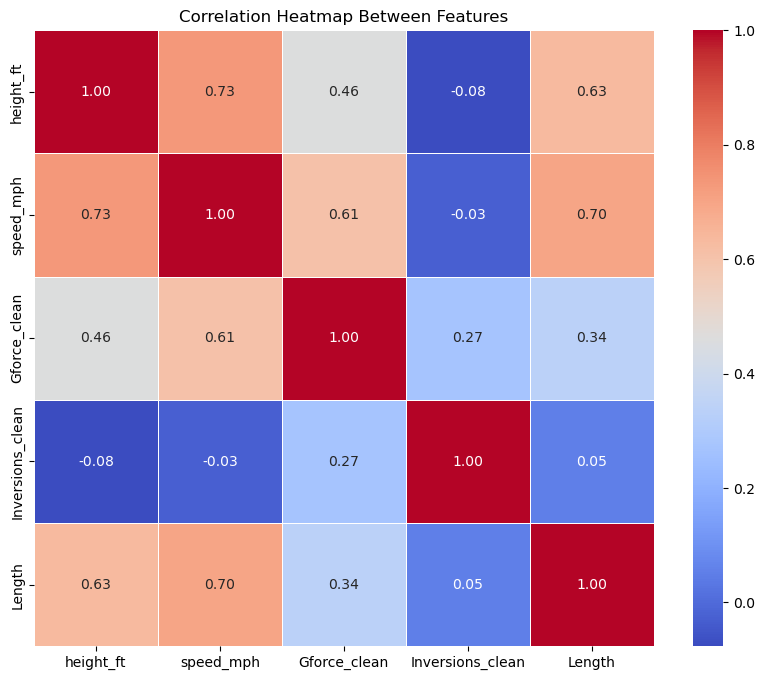

In [107]:
# Calculate the correlation matrix
correlation_matrix = coaster_data.corr()  # Assuming 'coaster_data' is your DataFrame

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add a title and display the plot
plt.title("Correlation Heatmap Between Features")
plt.show()

We can see that ```'speed_mph'``` and ```'height_ft'``` have a high correlation, which we explored in our Linear Regression notebook. ```'speed_mph'``` and ```'Gforce_clean'``` also have a high correlation at around 0.61. Based on this, I estimate that we only need to keep the top 3 principal components for our data.

Now, I will perform PCA to determine the top components.

In [97]:
# Scaling Data to account for outliers

coaster_features = coaster_data[['height_ft','speed_mph','Gforce_clean','Inversions_clean','Length']]

scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(coaster_features.to_numpy())

transformed_data_coaster, explained_variance_coaster = pca(numeric_data_scaled,5)


Now, let's evaluate how good our principal component analysis is by plotting the proportion of variance explained by each component feature in descending order. This is what we called a **scree plot**.

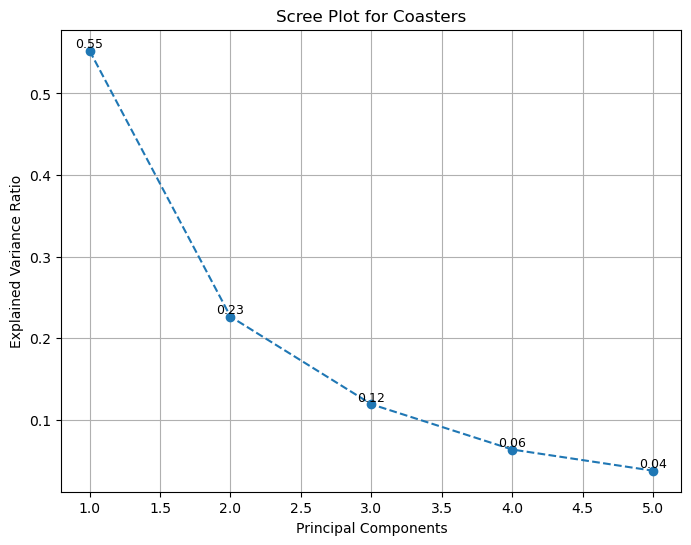

In [89]:

# Plot the Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_coaster) + 1), explained_variance_coaster, marker='o', linestyle='--')

# Add annotations on top of each point
for i, var_ratio in enumerate(explained_variance_coaster):
    plt.text(i + 1, var_ratio, f'{var_ratio:.2f}', ha='center', va='bottom', fontsize=9)

plt.title('Scree Plot for Coasters')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


We can see that the first principal component occupies most of our variation. Perhaps this corresponds to the general size of a roller coaster, which accounts for features like length, height, and top speed. If we once again use the Elbow-Method to determine a good trade off between capturing variation and efficiency, it seems like taking the top 3 components is good. These account for 90% of the variance in our data!

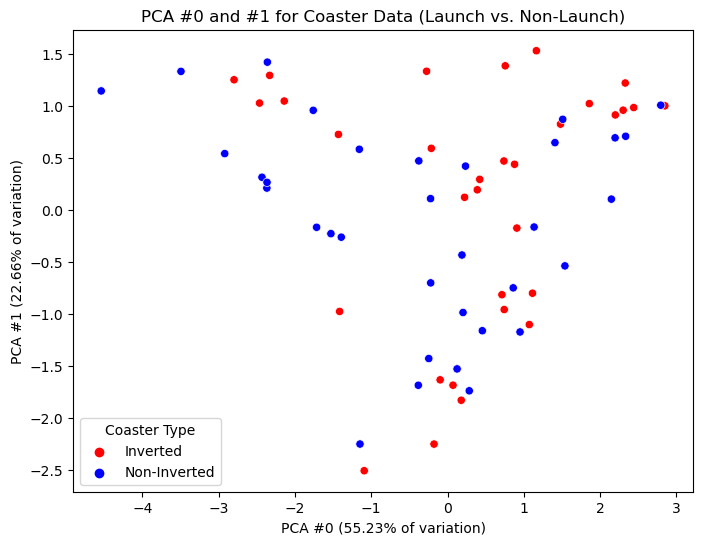

In [106]:
# Combine the two DataFrames back together
combined_coasters = pd.concat([inverted, non_inverted])

# Concatenate PCA results for both subsets
transformed_data_combined = np.concatenate([
    transformed_data_coaster[:len(inverted)],  # First part of PCA data for the 'inverted' subset
    transformed_data_coaster[len(inverted):]   # Second part of PCA data for the 'non_inverted' subset
])

# Add the transformed PCA data to the combined_coasters DataFrame
combined_coasters['PCA_0'] = transformed_data_combined[:, 0]
combined_coasters['PCA_1'] = transformed_data_combined[:, 1]

# Plot the scatter plot with different colors for 'Launch' and 'Non-Launch'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_coasters, x='PCA_0', y='PCA_1', hue='PCA_Type', palette=['red', 'blue'])
plt.xlabel(f"PCA #0 ({round(100 * explained_variance_coaster[0], 2)}% of variation)")
plt.ylabel(f"PCA #1 ({round(100 * explained_variance_coaster[1], 2)}% of variation)")
plt.title("PCA #0 and #1 for Coaster Data (Launch vs. Non-Launch)")
plt.legend(title="Coaster Type")
plt.show()


Here, we can see a scatter plot of our data based on the top 2 principal components with inverted coasters and non-inverted coasters shaded different colors. 